In [4]:
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
import sklearn
from sklearn.ensemble import ExtraTreesRegressor
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [37]:
def r_metric(x,y):
    tmp = 1.0 - ((x - y) ** 2.0).sum() / ((x - x.mean()) ** 2.0).sum()
    return np.sign(tmp) * np.sqrt(np.abs(tmp)) * 1.0
with pd.HDFStore("train.h5", "r") as train:
    # Note that the "train" dataframe is the only dataframe in the file
    df = train.get("train")

In [6]:
tmp = pd.DataFrame(df.timestamp.unique(), columns = ['timestamp'])
tmp ['std'] = df.groupby("timestamp")['y'].std()
df = pd.merge(df, tmp, how='right', on=['timestamp'])

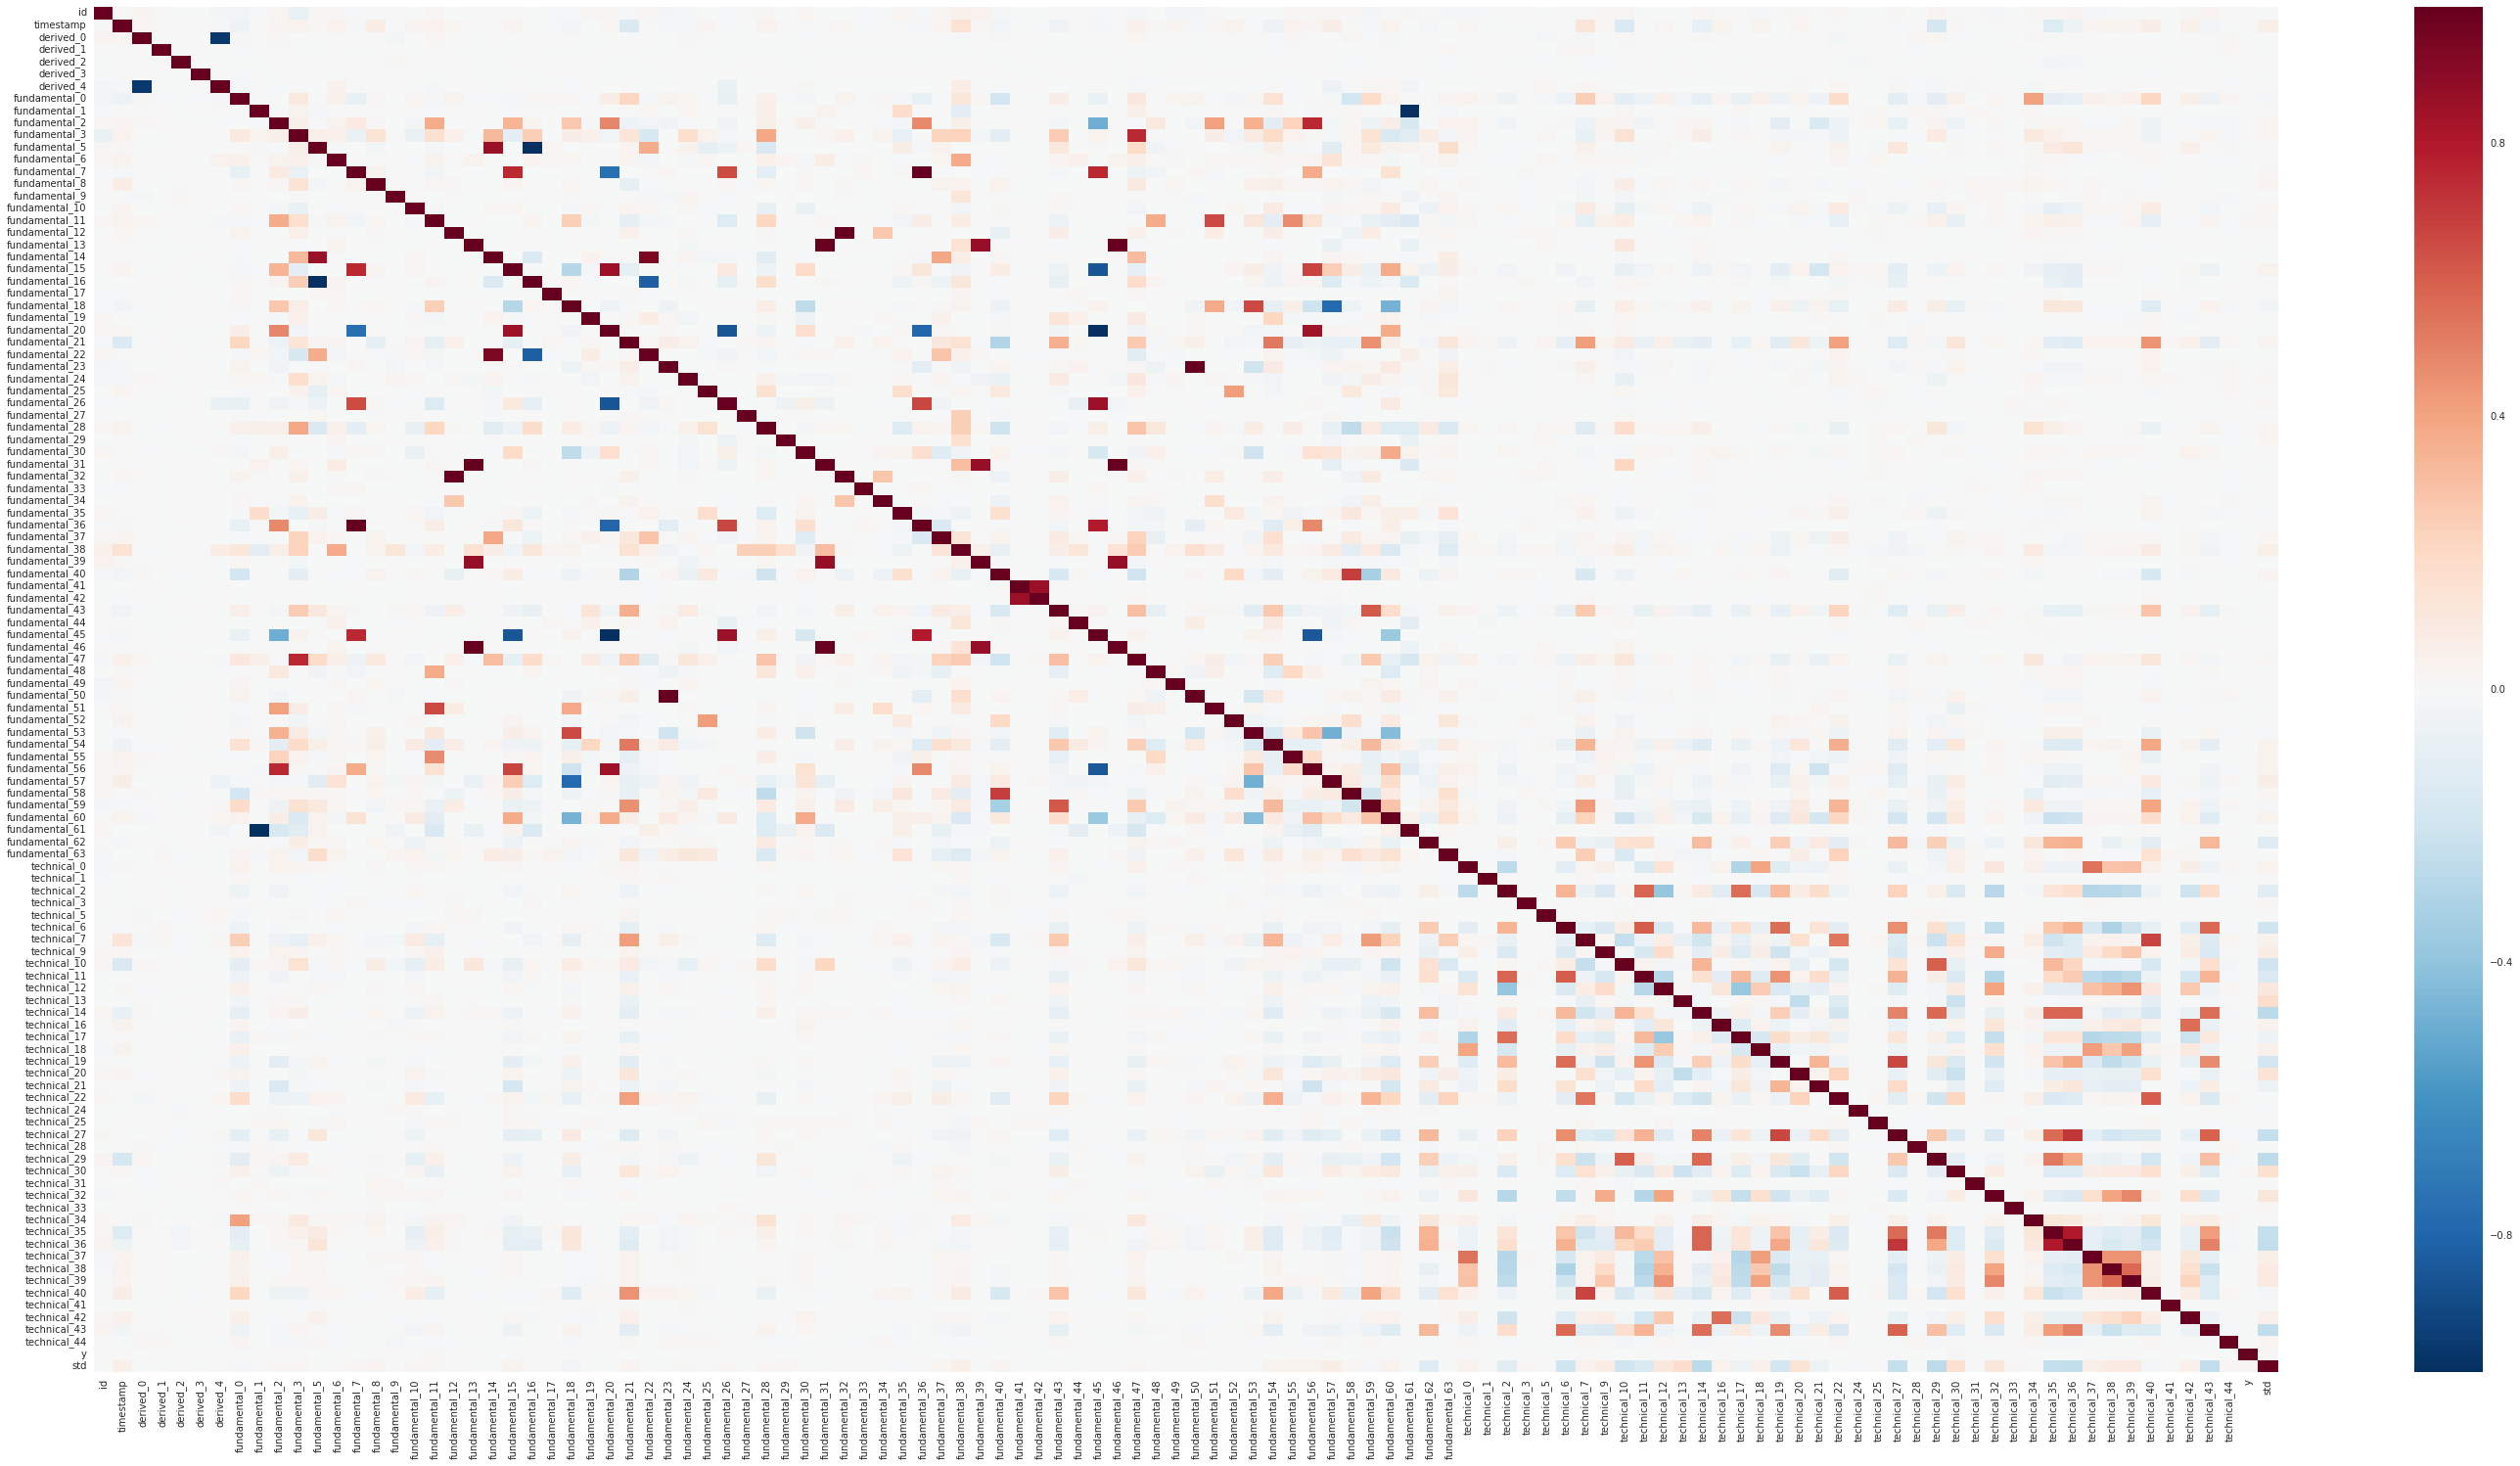

In [137]:
import seaborn as sns
CorrKoef = df.corr()
pylab.figure(figsize=(50, 25))
sns.heatmap(CorrKoef, annot=False)

In [38]:
ind_vol = [ 28.35, 28.64, 25.48, 22.64, 19.06, 21.62, 24.92, 31.93, 33.56, 23.84, 23.80, 21.09, 21.59, 17.40, 21.91, 19.98, 25.40, 32.03, 32.64, 39.69, 31.14,
27.50, 28.62, 31.17, 29.63, 29.15, 21.21, 19.47, 19.52, 19.49, 18.63, 22.72, 16.10, 16.32, 18.31, 16.63, 14.55, 16.74, 17.19, 15.50, 14.34, 15.32, 15.29,
13.34, 16.27, 13.24, 13.29, 12.82, 12.08, 14.02, 15.31, 13.29, 12.04, 11.57, 12.60, 11.92, 15.32, 12.06, 12.07, 12.95, 12.34, 11.39, 11.59, 16.44, 13.08,
14.95, 12.31, 11.98, 11.10, 10.91, 11.56, 10.42, 15.42, 14.64, 14.22, 13.05, 16.23, 23.52, 23.38, 18.00, 18.53, 22.87, 22.50, 26.20, 26.54, 25.61, 20.79,
17.83, 23.95, 22.94, 20.65, 39.39, 59.89, 55.28, 40, 44.84, 46.35, 44.14, 36.50, 28.92, 26.35, 25.92, 26.01, 25.61, 30.69, 24.51, 21.68, 24.62]

In [39]:
ind_vol = pd.DataFrame(ind_vol, columns = ['vol'])
ind_vol.index = 17.0 * ind_vol.index 
time = pd.DataFrame(index = range(1820))
time['nu'] = 0
for i in ind_vol.index:
    time.ix[i, 'nu'] = ind_vol.ix[i, 'vol']
last = ind_vol.index[0]
for i in ind_vol.index:
    if i != ind_vol.index[0]:
        raz = (ind_vol.ix[i, 'vol'] - ind_vol.ix[last, 'vol']) / (i - last) * 1.0
        for j in range(int(last), int(i)):
            time.ix[j, 'nu'] = ind_vol.ix[last, 'vol'] + (j - last) * raz        
        last = i

In [40]:
df['vol'] = 0
for i in time.index:
    df.ix[df.timestamp == i, 'vol'] = time.ix[i, 'nu']
df.vol = df.vol / 1009.0

In [41]:
train_data = df[df.timestamp < 1300]
#train_data = train_data[train_data.timestamp > 300]
test_data = df[df.timestamp >= 1300]
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

d_mean= train_data.mean(axis=0)
train_data.fillna(d_mean, inplace = True)
d_mean= test_data.median(axis=0)
test_data.fillna(d_mean, inplace = True)

train_labels = train_data.y
train_labels = pd.DataFrame(train_labels)
del train_data['y']


test_labels = test_data.y
test_labels = pd.DataFrame(test_labels)
del test_data['y']

In [42]:
no = ['timestamp', 'id']
tech = [c for c in train_data.columns if c not in no]
train_timestamp = pd.DataFrame(train_data.timestamp)
test_timestamp = pd.DataFrame(test_data.timestamp)


d_mean= train_data.median(axis=0)
n = train_data.isnull().sum(axis=1)
#train_data['minus'] = train_data['technical_20'] - train_data['technical_30']
train_data = train_data[tech]
#train_data = train_data[best.values]
for c in train_data.columns:
    train_data[c + '_nan_'] = pd.isnull(train_data[c])
    d_mean[c + '_nan_'] = 0
train_data = train_data.fillna(d_mean)
train_data['znull'] = n
n = []

n = test_data.isnull().sum(axis=1)
#test_data['minus'] = test_data['technical_20'] - test_data['technical_30']
test_data = test_data[tech]
#test_data = test_data[best.values]
for c in test_data.columns:
    test_data[c + '_nan_'] = pd.isnull(test_data[c])
test_data = test_data.fillna(d_mean)
test_data['znull'] = n



In [140]:
test_data.shape

(525007, 220)

In [74]:
import xgboost as xgb
dtrain = xgb.DMatrix(data = train_data, label = train_labels)
param = {'max_depth':3,
         'eta':0.4,
         'silent':1,
         'eval_metric': 'mae',
         'objective':'reg:linear',
         'min_child_weight': 10}
num_round = 60

In [75]:
bst = xgb.train(param, dtrain, num_round)

In [76]:
bst_pred = bst.predict(xgb.DMatrix(data = test_data))

In [77]:
pred = pd.DataFrame()
pred['y'] = bst_pred
print r_metric(test_labels, pred.values)

pred['real'] = test_labels.values
pred['time'] = pd.DataFrame(test_timestamp.values)

r_time = []
for i in range(1300, 1813, 1):
    r_time += [r_metric(pred.real[pred.time <= i], pred.y[pred.time <= i])]
    
r_time_bst = r_time

y   -0.214159
dtype: float64


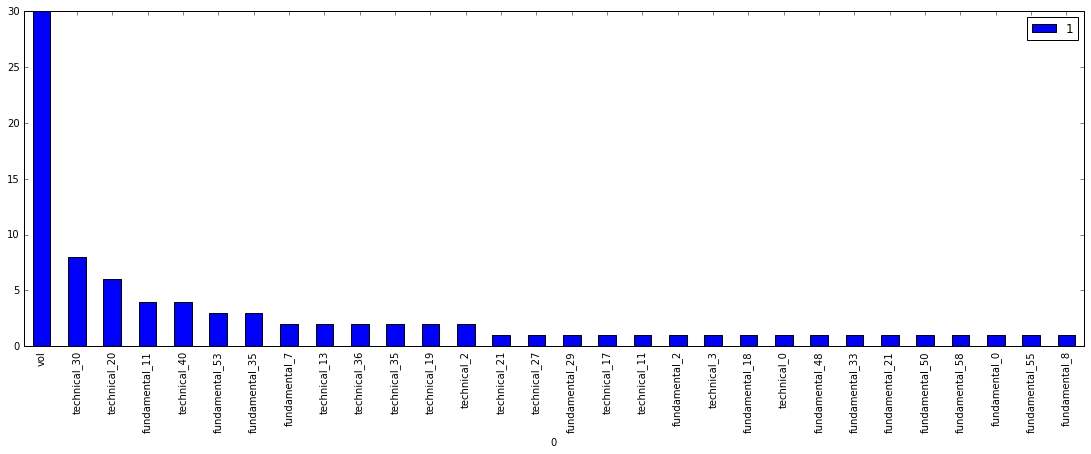

In [57]:
imp = pd.DataFrame(bst.get_fscore().items()).sort_values(1, ascending=False)
imp.index = imp[0]
imp[:80].plot(kind = "bar", figsize=(19, 6))
plt.show()
best = imp[:80].index

In [33]:
r_time_rf_fund = pd.read_csv("models/r_time_rf_fund.csv")
r_time_0 = pd.read_csv("models/r_time_0.csv")


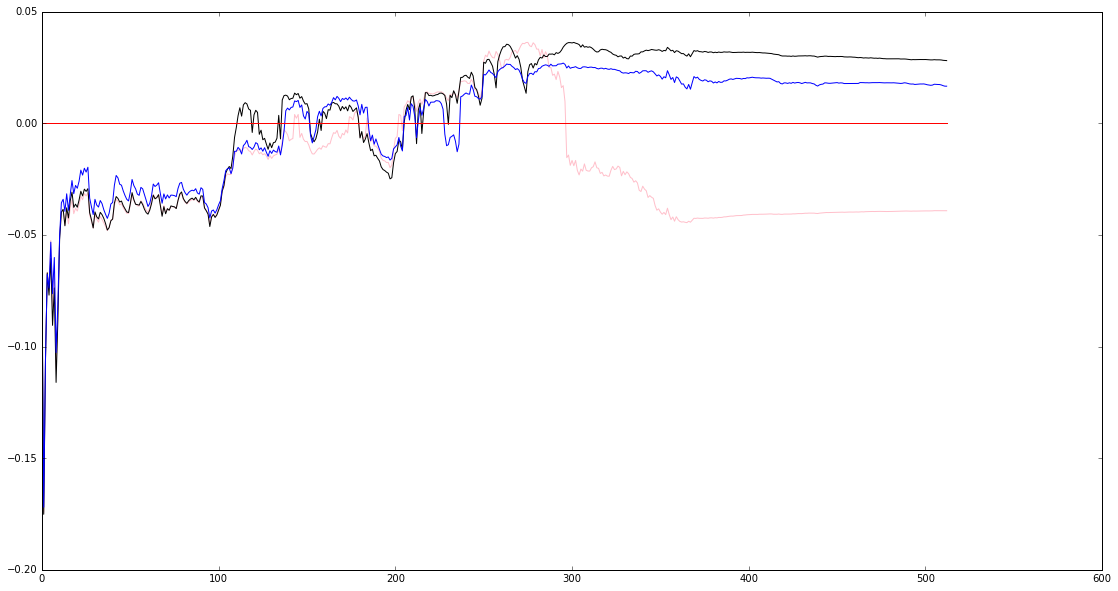

In [52]:
plt.figure(figsize=(19, 10))
plt.plot(r_time_extr_std_vol, c='pink')
plt.plot(r_time_rf_fund, c='black')
plt.plot(r_time_0, c='blue')
#plt.plot(r_time_extr_std, c='green')
#plt.plot(r_time_rf_std, c='orange')

plt.plot( [0]*len(r_time), c='red')

In [167]:
reg = LinearRegression()
reg.fit(pd.DataFrame(train_data['std']), train_labels)
re = reg.predict(pd.DataFrame(test_data['std']))
r_metric(test_labels, re)

y    0.011704
dtype: float64

In [43]:
rfr = ExtraTreesRegressor(n_estimators=100, max_depth=4, n_jobs=-1, random_state=17, verbose=0)
model1 = rfr.fit(train_data, train_labels)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [49]:
pred = pd.DataFrame()
pred['y'] = model1.predict(test_data)#.clip(-0.075, 0.075)
r_metric(test_labels, pred.values)

y   -0.039126
dtype: float64

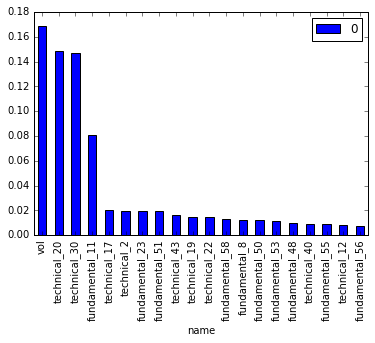

In [50]:
r = pd.DataFrame(model1.feature_importances_)
r['name'] = test_data.columns.values
#r['name'] = cols
r.index = r['name']
del r['name']
r = r.sort_values(0, ascending=False)
pylab.figure(figsize=(18, 6))
r[:20].plot(kind = "bar")
plt.show()

In [51]:
pred['real'] = test_labels.values
pred['time'] = pd.DataFrame(test_timestamp.values)

r_time = []
for i in range(1300, 1813, 1):
    r_time += [r_metric(pred.real[pred.time <= i], pred.y[pred.time <= i])]
    
r_time_extr_std_vol = r_time

In [173]:
forest_regressor = sklearn.ensemble.RandomForestRegressor(n_estimators=45,
                                       criterion='rmse',
                                       max_depth=5,
                                       #min_samples_split=2,
                                       #min_samples_leaf=1,
                                       #min_weight_fraction_leaf=0.0,
                                       max_features='auto',
                                       #max_leaf_nodes=None,
                                       bootstrap=True,
                                       #oob_score=False,
                                       n_jobs=-1,
                                       random_state=None)

In [ ]:
forest_regressor.fit(train_data, train_labels)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


In [ ]:
forest_pred = forest_regressor.predict(test_data).clip(-0.075, 0.075)
e = pd.DataFrame()
e['y'] = forest_pred
r_metric(test_labels, e.values)

In [ ]:
e = pd.DataFrame(e, columns = ['y'])
e['real'] = test_labels.values
e['time'] = test_timestamp.values

r_time = []
for i in range(1300, 1813, 1):
    r_time += [r_metric(e.real[e.time <= i], e.y[e.time <= i])]

r_time_rf_std = r_time